# Problem Set 2

In this Problem Set we will get back to the songs dataset and see how we can discover new dimensions within, either looking directly at the songs, or aggregating at the artist leve.

## Fightin' words

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#LOAD THE SAME DATA WE USED FOR CLASS 4
import json
df = pd.read_json("/content/gdrive/MyDrive/Songs.json", lines=True)
df['tokens_simple'] = [json.loads(x) for x in df['tokens_simple']]

In [ ]:
df.head()

,artist,song,tokens_simple
0,ABBA,Ahe's My Kind Of Girl,"[look, at, her, face, it, be, wonderful, face,..."
1,ABBA,"Andante, Andante","[take, it, easy, with, please, touch, gently, ..."
2,ABBA,As Good As New,"[will, never, know, why, have, to, go, why, ha..."
3,ABBA,Bang,"[make, somebody, happy, be, question, of, give..."
4,ABBA,Bang-A-Boomerang,"[make, somebody, happy, be, question, of, give..."


In [ ]:
df['tokens_simple'][0]

['look',
 'at',
 'her',
 'face',
 'it',
 'be',
 'wonderful',
 'face',
 'and',
 'it',
 'mean',
 'something',
 'special',
 'to',
 'look',
 'at',
 'the',
 'way',
 'that',
 'she',
 'smile',
 'when',
 'she',
 'see',
 'how',
 'lucky',
 'can',
 'one',
 'fellow',
 'be',
 'she',
 'be',
 'just',
 'my',
 'kind',
 'of',
 'girl',
 'she',
 'make',
 'feel',
 'fine',
 'who',
 'could',
 'ever',
 'believe',
 'that',
 'she',
 'could',
 'be',
 'mine',
 'she',
 'be',
 'just',
 'my',
 'kind',
 'of',
 'girl',
 'without',
 'she',
 'be',
 'blue',
 'and',
 'if',
 'she',
 'ever',
 'leave',
 'what',
 'could',
 'do',
 'what',
 'could',
 'do',
 'and',
 'when',
 'we',
 'go',
 'for',
 'walk',
 'in',
 'the',
 'park',
 'and',
 'she',
 'hold',
 'and',
 'squeeze',
 'my',
 'hand',
 'we',
 'will',
 'go',
 'on',
 'walk',
 'for',
 'hour',
 'and',
 'talk',
 'about',
 'all',
 'the',
 'thing',
 'that',
 'we',
 'plan',
 'she',
 'be',
 'just',
 'my',
 'kind',
 'of',
 'girl',
 'she',
 'make',
 'feel',
 'fine',
 'who',
 'could',
 '

In [ ]:
#Let's compare the Foo Fighters and the Beatles. As we already did in Class 4, we need to put together two lists of lists, as this is what the function expects.

foo=[]
beatles=[]

#Update these two empy lists with the tokens in the dataset
for index, row in df.iterrows():
    if row['artist']=='Foo Fighters':
        foo.append(" ".join(row['tokens_simple']))
    elif row['artist']=='The Beatles':
        beatles.append(" ".join(row['tokens_simple']))

We now want to calculate Fightin' Words using a prior that we compute from the corpus. Here we are following the steps described in Monroe, Colaresi and Quinn (2008), section 3.5.1. We need to form our prior and to do that we are using all songs from all artists. Look at footnote 18.

In [ ]:
#Here we vectorize using the whole dataset of songs to create a vocabulary we can use for the prior.
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=None,
                             lowercase=False,
                             min_df=0.001,
                             max_df=.9,
                             max_features=10000,
                             binary=False
                             )

X = vectorizer.fit_transform(df['tokens_simple'].apply(lambda tokens: " ".join(tokens)))

To form our prior we need first to look at the frequency of each token in the overall dataset. Then we need to choose a level of $\alpha_0$. The higher $\alpha_0$, the stronger the influence of our prior.

In [ ]:
token_counts = np.array(X.sum(axis=0)).flatten()

# Calculate the total sum of all token counts
total_sum_of_counts = token_counts.sum()

# Calculate the frequency of each token by dividing each count by the total sum of counts
token_frequencies = token_counts / total_sum_of_counts

#Create a list containing tokens and their frequency
tokens = [[i, token_frequencies[vectorizer.vocabulary_[i]]] for i in vectorizer.vocabulary_ ]

# Create a DataFrame with tokens and their frequencies
token_frequency_df = pd.DataFrame(tokens, columns=['token', 'frequency'])

We now need to setup another vectorizer that we will use for the songs we are interested in. In this case notice that we are forcing the vocabulary to be equal to the one obtained in the previous step.


### Question 1:
Change the cell below to use the correct vocabulary.

In [ ]:
vectorizer2 = CountVectorizer(tokenizer=None,
                              lowercase=False,
                              max_features=10000,
                              binary=False,
                              vocabulary=vectorizer.vocabulary_
                             )

In [ ]:
#Here we are using the same function we described in class. As we now want to
#specify priors, pay attention to the instructions.

from sklearn.feature_extraction.text import CountVectorizer as CV
import string
exclude = set(string.punctuation)

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''
    in_string = ''.join([ch for ch in in_string if ch not in exclude])
    in_string = in_string.lower()
    in_string = ' '.join(in_string.split())
    return in_string

def bayes_compare_language(l1, l2, ngram = 1, prior=.01, cv = None):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.

    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]
    if cv is None:
        cv = CV(decode_error = 'ignore', min_df=0.005,
                max_df=.9, ngram_range=(1,ngram),
                binary = False,
                max_features = 15000)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v:k for k,v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = []
    for i in sorted_indices:
        return_list.append((index_to_term[i], z_scores[i]))
    return return_list

In [ ]:
scores_uninformative = bayes_compare_language(foo, beatles, ngram = 1, prior=0.1, cv = vectorizer2)
scores_informative_1 = bayes_compare_language(foo, beatles, ngram = 1, prior=token_frequencies*100, cv = vectorizer2)
scores_informative_2 = bayes_compare_language(foo, beatles, ngram = 1, prior=token_frequencies*1000, cv = vectorizer2)
scores_informative_3 = bayes_compare_language(foo, beatles, ngram = 1, prior=token_frequencies*10000, cv = vectorizer2)
scores_informative_4 = bayes_compare_language(foo, beatles, ngram = 1, prior=token_frequencies*100000, cv = vectorizer2)

Vocab size is 4191
Comparing language...
Vocab size is 4191
Comparing language...
Vocab size is 4191
Comparing language...
Vocab size is 4191
Comparing language...
Vocab size is 4191
Comparing language...


### Question 2:
Describe in your own words how we are using `token_frequencies`, and how we are using `vectorizer2`. What changes when we multiply `token_frequencies` by a number?

token_frequency measures the word frequency by counting how often each word appears or the probability of the words' appearance, which serve as a prior in Bayesian comparisons.

We are using vectorizer2 by first using the vocabulary from vectorizer.vocabulary_, and compare the usage of words of the two singers to the vocabulary.

Multiplying token_frequencies by a number changes the prior we apply in the comparison. Multiplying by a large number helps to identify the rare words favored by one artist, and by a small number shows the words favored by both artist.

In [ ]:
scores_uninformative[0:10]

[('love', -12.780353377341077),
 ('she', -12.245887767568547),
 ('yeah', -9.680067402508188),
 ('well', -8.960986366623917),
 ('baby', -7.42827331931619),
 ('girl', -7.199432362471308),
 ('do', -6.852651169942033),
 ('cry', -6.103810505121428),
 ('tell', -5.6771117234501896),
 ('hey', -5.601740006859243)]

In [ ]:
scores_informative_1[0:10]

[('love', -12.768888436449075),
 ('she', -12.23212594123836),
 ('yeah', -9.669365545711585),
 ('well', -8.947579426505783),
 ('baby', -7.410616074982241),
 ('girl', -7.194039283975539),
 ('do', -6.8173805060381305),
 ('cry', -6.100092254054673),
 ('tell', -5.66276896576493),
 ('hey', -5.593684628566273)]

In [ ]:
scores_informative_2[0:10]

[('love', -12.734032994693885),
 ('she', -12.194607519703002),
 ('yeah', -9.645034241408135),
 ('well', -8.904140744584998),
 ('baby', -7.331482187591045),
 ('girl', -7.193833016421704),
 ('do', -6.721919682154219),
 ('cry', -6.118077913570644),
 ('tell', -5.584888977990967),
 ('hey', -5.5645153631567075)]

In [ ]:
scores_informative_3[0:10]

[('love', -11.531670918265444),
 ('she', -11.42473003664414),
 ('yeah', -9.183609215393746),
 ('well', -8.40308982239685),
 ('girl', -6.792863980024584),
 ('baby', -6.607237526922103),
 ('cry', -5.940723527774735),
 ('do', -5.939007081828903),
 ('yes', -5.302372376666766),
 ('ah', -5.260608588732546)]

In [ ]:
scores_informative_4[0:10]

[('nah', -8.660195468114145),
 ('she', -6.766498784032481),
 ('love', -6.07570396512321),
 ('yeah', -5.819782118796756),
 ('well', -5.375336122329228),
 ('john', -4.785780144850518),
 ('hello', -4.546193864586496),
 ('bye', -4.206718634598177),
 ('honey', -4.113276149506957),
 ('girl', -3.9851690434121023)]

In [ ]:
scores_uninformative = pd.DataFrame(scores_uninformative, columns=['token', 'uninformative'])
scores_informative_1 = pd.DataFrame(scores_informative_1, columns=['token', 'informative_1'])
scores_informative_2 = pd.DataFrame(scores_informative_2, columns=['token', 'informative_2'])
scores_informative_3 = pd.DataFrame(scores_informative_3, columns=['token', 'informative_3'])
scores_informative_4 = pd.DataFrame(scores_informative_4, columns=['token', 'informative_4'])

In [ ]:
#Create a unique dataframe containing all the scores, make sure to merge on token
all = token_frequency_df.merge(scores_uninformative, on='token')
all = all.merge(scores_informative_1, on='token')
all = all.merge(scores_informative_2, on='token')
all = all.merge(scores_informative_3, on='token')
all = all.merge(scores_informative_4, on='token')

In [ ]:
all.sort_values(by='uninformative', ascending=True)[0:5]

,token,frequency,uninformative,informative_1,informative_2,informative_3,informative_4
131,love,0.010253,-12.780353,-12.768888,-12.734033,-11.531671,-6.075704
11,she,0.006749,-12.245888,-12.232126,-12.194608,-11.424730,-6.766499
795,yeah,0.003458,-9.680067,-9.669366,-9.645034,-9.183609,-5.819782
140,well,0.003274,-8.960986,-8.947579,-8.904141,-8.403090,-5.375336
158,baby,0.004236,-7.428273,-7.410616,-7.331482,-6.607238,-3.761346


In [ ]:
all.sort_values(by='uninformative', ascending=False)[0:5]

,token,frequency,uninformative,informative_1,informative_2,informative_3,informative_4
18,one,0.004763,9.497165,9.504124,9.405349,8.537697,5.043029
123,out,0.004385,8.212558,8.216711,8.117921,7.245560,4.035690
321,this,0.005727,7.386306,7.388057,7.267957,6.276392,3.257702
168,give,0.002783,6.637130,6.641455,6.563705,5.879311,3.314941
86,again,0.001886,6.500884,6.507027,6.446664,5.912882,3.622643


#### Question 3:
1. What are we showing in the two cells above?
2. Would you select these words as characterizing the two artists?
3. Which criterion would you follow to select the set of discriminating words?

Focus on the words shown above and look at how the scores differ as we move to uniformative to informative_1 up to informative_4.

4. What patterns do you notice?
5. Is the pattern you notice related to the frequency? (You don't need to run regressions).
6. What is your intuition for what is happening? How does this relate to the prior you are imposing? (Hint: For further insight, you may refer to the paper by Monroe, Colaresi, and Quinn (2008).)

1. The first cell is showing the words mostly related to Foo ordered by uninformative, and the second cell is showing the words most related to Beatles.
2. No. Because these words are based on a prior commonly used by the artist. We should use the informative words to discriminate the artists.
3. I would follow informative words.
4. The higher the number frequency is multiplied by to calculate the prior, the lower the informative score will be.
5. The higher the frequency, the higher the word is related to the corresponding artist.
6. If the prior is informative, the model will weigh the tokens in their occurance in the group, and therefore enhances the model's ability to identify special usages of the tokens.

## Introduction to TF-IDF Weighting
### See also book GRS Ch. 7.3

In this part of the problem set, we will attempt to improve upon the clustering exercise we conducted in Class 4. This time, we will introduce two changes. First, we will focus on artists. Second, we will utilize TF-IDF weighting.

This heuristic aims to scale each token by a quantity that is inversely proportional to the frequency of the token in the corpus. The goal is to identify words that are distinctively frequent in a document compared to a general corpus. This characteristic makes TF-IDF particularly useful for tasks such as clustering, classification, and feature selection.


In [ ]:
#Collapse at the artist level
df_artist = df.groupby('artist')['tokens_simple'].agg('sum').reset_index()


In [ ]:
#Here we vectorize using the tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=None,
                        max_features=15000,
                        use_idf=True,
                        lowercase=False,
                        ngram_range=(1,2),
                        max_df=0.90,
                        min_df=0.01,
                        token_pattern=r'(?u)\b\w{4,}\b',
                        sublinear_tf=True
                        )

X_tf = tfidf.fit_transform(df_artist['tokens_simple'].apply(lambda tokens: " ".join(tokens)))


In [ ]:
X_tf.shape

(643, 15000)

In [ ]:
#Here we vectorize using the count vectorizer
vectorizer3 = CountVectorizer(tokenizer=None,
                              lowercase=False,
                              max_features=15000,
                              binary=False,
                              ngram_range=(1,2),
                              max_df=0.90,
                              min_df=0.01,
                              token_pattern=r'(?u)\b\w{4,}\b'
)

X3 = vectorizer3.fit_transform(df_artist['tokens_simple'].apply(lambda tokens: " ".join(tokens)))

In [ ]:
X3.shape

(643, 15000)

We now want to understand whether the intuition behind td-idf is reflected in the scores. Since the scores are normalized, the range in which they move is different. We can anyway compare the two distributions, to see how important are relatively low values. In the next cell we will compare the shape of the two cumulative distributions.

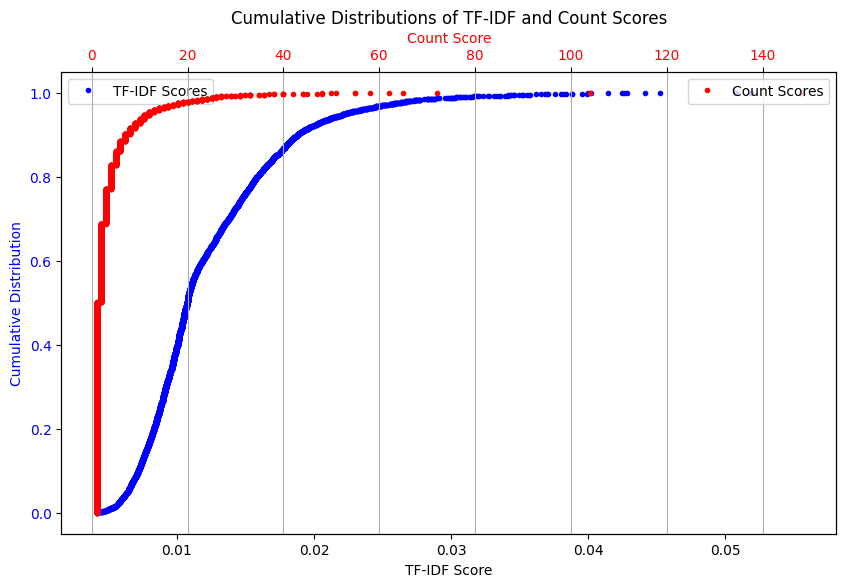

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# To illustrate this point, here we compare Bob Dylan (artist 40) in both distributions.
tfidf_scores = X_tf[40, :].toarray().flatten()  # Flatten the array to make it 1D
counts_scores = X3[40, :].toarray().flatten()  # Flatten the array to make it 1D

# Remove zeros if present to avoid issues with log scale
tfidf_scores = tfidf_scores[tfidf_scores > 0]
counts_scores = counts_scores[counts_scores > 0]

# Compute the cumulative distribution for each array
tfidf_sorted = np.sort(tfidf_scores)
counts_sorted = np.sort(counts_scores)
tfidf_cumulative = np.arange(1, len(tfidf_sorted) + 1) / len(tfidf_sorted)
counts_cumulative = np.arange(1, len(counts_sorted) + 1) / len(counts_sorted)

# Create the figure and the first axes (ax1) for the TF-IDF scores
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(tfidf_sorted, tfidf_cumulative, label='TF-IDF Scores', color='blue', marker='.', linestyle='none')
ax1.set_xlabel('TF-IDF Score')
ax1.set_ylabel('Cumulative Distribution', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second axes (ax2) for the count scores, sharing the same y-axis
ax2 = ax1.twiny()  # Creates a new x-axis that shares the same y-axis
ax2.plot(counts_sorted, counts_cumulative, label='Count Scores', color='red', marker='.', linestyle='none')
ax2.set_xlabel('Count Score', color='red')
ax2.tick_params(axis='x', labelcolor='red')

# Optional: Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adding a title and grid
plt.title('Cumulative Distributions of TF-IDF and Count Scores')
plt.grid(True)

plt.show()


### Question 4:
What can you say about the two distributions by comparing the cumulative distribution functions above? How do you interpret the fact that the distribution for the counts lies above the distribution for the TF-IDF scores? Does this pattern confirm what you were expecting in terms of distribution of scores?

The count score is much higher than the TF-IDF score, which means many terms have higher count scores than the TF-IDF expected. Bob Dylan uses frequently-used words more than TF-IDF thought based on the corpus.

Yes, because it is typicaal that common words dominate frequent counts, and those with high TF-IDF scores are distinctively used words. Bob Dylan is an artists that writes commonly moving songs with common words.

### K-Means Clustering

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
X_tf = X_tf.todense()
X_tf = np.asarray(X_tf)

X3 = X3.todense()
X3 = np.asarray(X3)

For a definition of Inertia, you can see the scikit-learn explantion of the method: https://scikit-learn.org/stable/modules/clustering.html#k-means
For an idea of what the elbow method is, you can look here: https://en.wikipedia.org/wiki/Elbow_method_(clustering). This method is similar to methods suggested for Principal Component Analysis. As we will see, results with text data with so many dimensions do not lead to clear cut results that we tipically hope for.

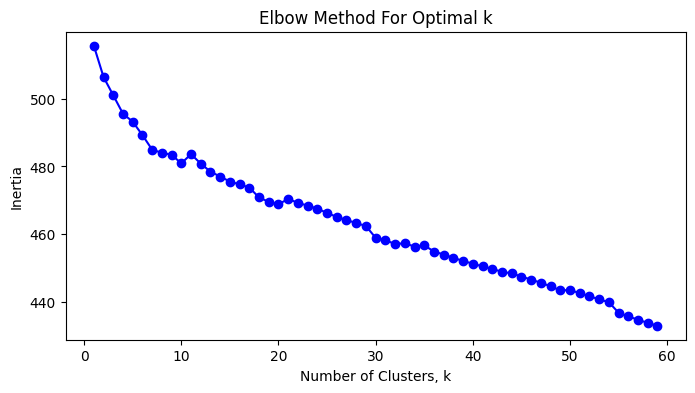

In [ ]:
# Calculate inertia for a range of k values
inertias = []
k_range = range(1,60)  # Adjust the range of k as needed
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_tf)
    inertias.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

### Question 5:
The elbow method applied using inertia would require to spot a number of clusters above  which we see inertia becoming relatively flat.
Given the results in the previous cell, what would be your conclusions? Which range of number of clusters would you consider?

Inertia after 10 is relatively flat seen from the graph. I would conclude the elbow point is somewhere near 7. I would consider 6,7,8 as the number of clusters.

Silhouette scores are another method to evaluate the quality of the clusters. See for example here: https://en.wikipedia.org/wiki/Silhouette_(clustering) or the scikit learn guide in Class 4.

In [ ]:
sil_scores = []
for n in range(2, 21):
    km = KMeans(n_clusters=n, n_init='auto', random_state=42)
    km.fit(X_tf)
    sil_scores.append(silhouette_score(X_tf, km.labels_))

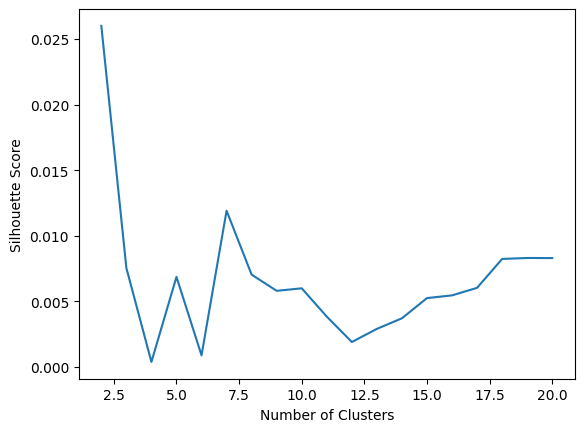

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(2, 21), sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Question 6:

According to the scores above, which number of cluster would you consider? You can specify a range.

NOTE: There is no strictly correct answer as long as you provide an argument to motivate your choice.


From the Silhoutte Score, it is high when the number of clusters is around 7.5, therefore it would be optimal to choose 7 or 8 as the number of clusters.

For n_clusters = 6, The average silhouette_score is : 0.0008970644653745628
For n_clusters = 7, The average silhouette_score is : 0.011919968263694387
For n_clusters = 8, The average silhouette_score is : 0.007044184548538455


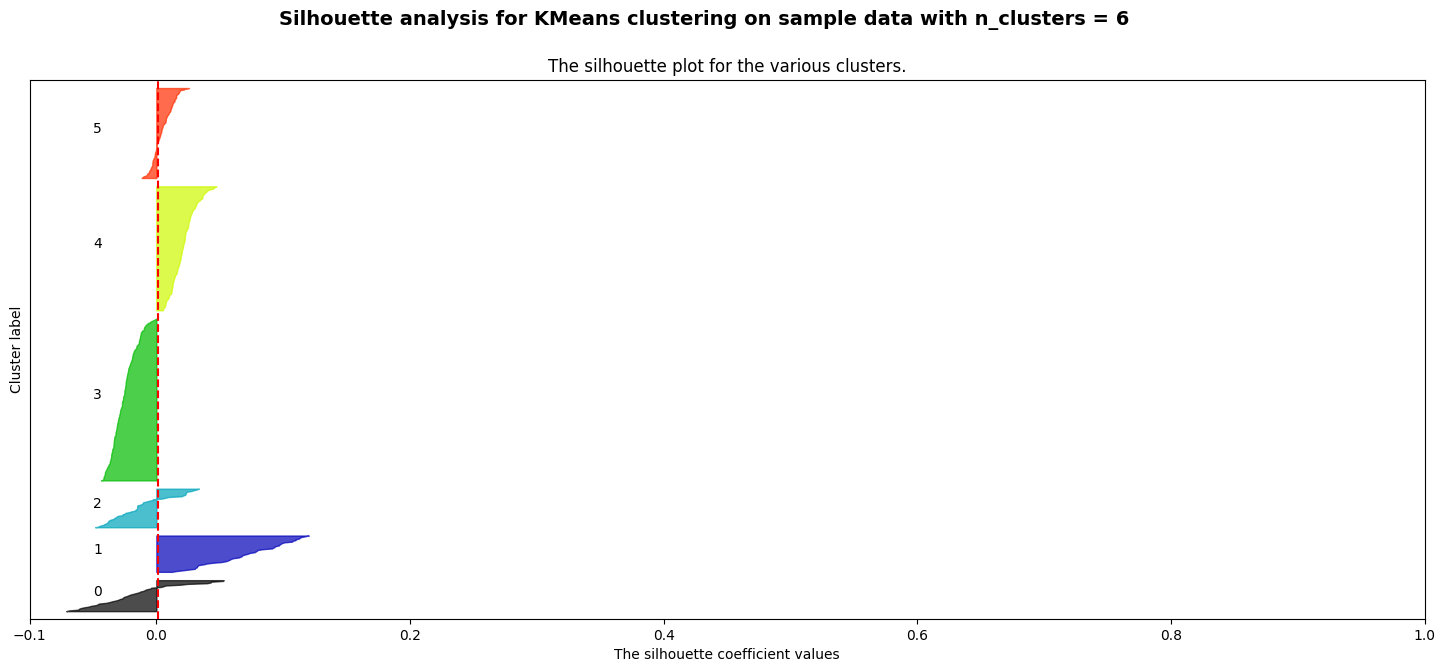

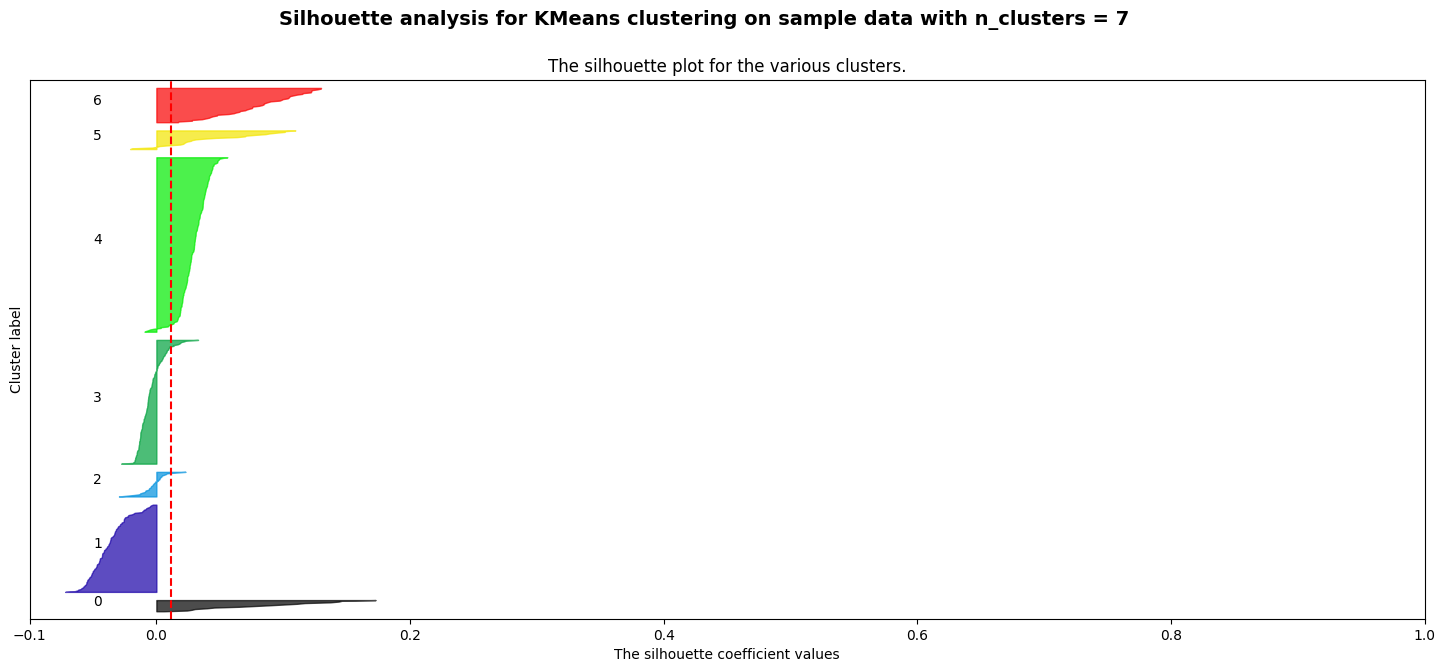

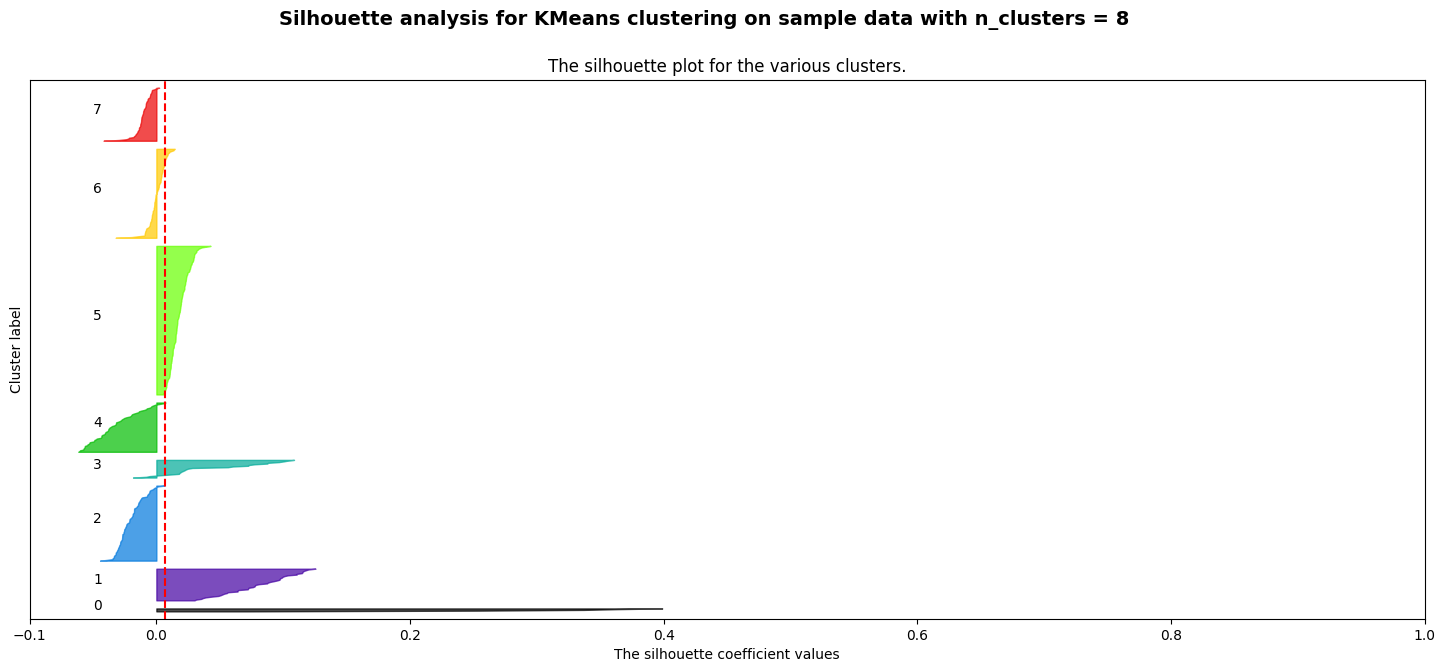

In [ ]:
import matplotlib.cm as cm

# Assuming X is your dataset
range_n_clusters = [6,7,8] #INSERT A NUMBER OR A RANGE

for n_clusters in range_n_clusters:
    # Create a subplot
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # Set limits for the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # Inserting blank space between silhouette plots of individual clusters
    ax1.set_ylim([0, len(X_tf) + (n_clusters + 1) * 10])

    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    cluster_labels = clusterer.fit_predict(X_tf)

    # The silhouette_score gives the average value for all the samples
    silhouette_avg = silhouette_score(X_tf, cluster_labels)
    print(f"For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_tf, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate and sort silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers in the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}", fontsize=14, fontweight="bold")

plt.show()

### Question 7:
In light on the discussion presented in the scikit-learn tutorial (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html), how would you comment the results above? Are there clusters that seem well identified? Can you say the same for all clusters?

Among those 3 clustering numbers, 7 clusters has the highest Silhoutte score, which is still not close to 1. However, if we look in detail in the clusters, when n=7, cluster 0,5,6 are well identified. There are also cases when n=6 or 8.

Let's now focus on data at the artist level, to understand whether this subdivision in clusters could be helpful in discovering other artists similar artists we already know.

In [ ]:
clusters = KMeans(n_clusters=7, n_init='auto', random_state=42)
cluster_labels = clusters.fit_predict(X_tf)
cluster_labels = pd.DataFrame(cluster_labels, columns=['cluster'])

In [ ]:
cluster_labels.head(10)

,cluster
0,4
1,4
2,4
3,6
4,4
5,4
6,4
7,0
8,4
9,3


In [ ]:
df_artist.head(10)

,artist,tokens_simple
0,'n Sync,"[girl, do, not, say, that, it, be, over, cause..."
1,ABBA,"[look, at, her, face, it, be, wonderful, face,..."
2,Ace Of Base,"[always, have, always, will, be, mesmerize, wh..."
3,Adam Sandler,"[hello, mudda, hello, fadda, here, be, at, cam..."
4,Adele,"[verse, will, leave, my, heart, at, the, door,..."
5,Aerosmith,"[all, your, love, miss, lovin, all, your, kiss..."
6,Air Supply,"[for, certain, she, be, the, face, of, springt..."
7,Aiza Seguerra,"[before, you, go, away, to, the, one, you, do,..."
8,Alabama,"[call, call, all, angel, oh, be, call, call, a..."
9,Alan Parsons Project,"[the, stake, be, high, we, have, to, seize, th..."


In [ ]:
merged_df = df_artist.merge(cluster_labels, left_index=True, right_index=True)
merged_df['text'] = merged_df['tokens_simple'].apply(' '.join)

In [ ]:
merged_df.describe()

,cluster
count,643.000000
mean,3.171073
std,1.473114
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


In [ ]:
merged_df.head()

,artist,tokens_simple,cluster,text
0,'n Sync,"[girl, do, not, say, that, it, be, over, cause...",4,girl do not say that it be over cause you be p...
1,ABBA,"[look, at, her, face, it, be, wonderful, face,...",4,look at her face it be wonderful face and it m...
2,Ace Of Base,"[always, have, always, will, be, mesmerize, wh...",4,always have always will be mesmerize when firs...
3,Adam Sandler,"[hello, mudda, hello, fadda, here, be, at, cam...",6,hello mudda hello fadda here be at camp granad...
4,Adele,"[verse, will, leave, my, heart, at, the, door,...",4,verse will leave my heart at the door will not...


### Question 8:
What are we doing in the cell above?

Create a Kmeans clustering and merge the cluster number with the original artist dataframe, for it to show the number of hte clusters of the songs.

Let's focus on  artists we already know and see which cluster they are assigned to.

In [ ]:
merged_df.loc[merged_df['artist']=="The Beatles"]

,artist,tokens_simple,cluster,text
491,The Beatles,"[well, if, your, hand, start, clappin, and, yo...",4,well if your hand start clappin and your finge...


In [ ]:
merged_df.loc[merged_df['cluster']==3].head(10)

,artist,tokens_simple,cluster,text
9,Alan Parsons Project,"[the, stake, be, high, we, have, to, seize, th...",3,the stake be high we have to seize the chance ...
11,Alice Cooper,"[but, over, in, land, that, be, in, my, back, ...",3,but over in land that be in my back yard there...
12,Alice In Chains,"[sit, on, an, angry, chair, angry, wall, that,...",3,sit on an angry chair angry wall that steal th...
15,Alphaville,"[acrobat, and, comet, float, by, so, fast, chi...",3,acrobat and comet float by so fast children fa...
24,Arrogant Worms,"[baby, wanna, tell, you, all, my, hope, and, d...",3,baby wanna tell you all my hope and dream and ...
30,Beautiful South,"[the, part, of, love, that, be, scared, of, be...",3,the part of love that be scared of be the actu...
38,Black Sabbath,"[what, do, you, say, to, the, dead, will, you,...",3,what do you say to the dead will you forgive f...
39,Blur,"[pick, up, the, girl, and, he, sail, around, t...",3,pick up the girl and he sail around the world ...
53,Cake,"[stand, in, the, alpha, beta, parking, lot, wa...",3,stand in the alpha beta parking lot watch the ...
72,Clash,"[now, the, corporation, stop, stop, push, fast...",3,now the corporation stop stop push fast food b...


In [ ]:
merged_df.loc[merged_df['artist']=="Foo Fighters"]

,artist,tokens_simple,cluster,text
151,Foo Fighters,"[all, my, life, have, be, search, for, somethi...",3,all my life have be search for something somet...


In [ ]:
merged_df.loc[merged_df['cluster']==3].head(10)

,artist,tokens_simple,cluster,text
9,Alan Parsons Project,"[the, stake, be, high, we, have, to, seize, th...",3,the stake be high we have to seize the chance ...
11,Alice Cooper,"[but, over, in, land, that, be, in, my, back, ...",3,but over in land that be in my back yard there...
12,Alice In Chains,"[sit, on, an, angry, chair, angry, wall, that,...",3,sit on an angry chair angry wall that steal th...
15,Alphaville,"[acrobat, and, comet, float, by, so, fast, chi...",3,acrobat and comet float by so fast children fa...
24,Arrogant Worms,"[baby, wanna, tell, you, all, my, hope, and, d...",3,baby wanna tell you all my hope and dream and ...
30,Beautiful South,"[the, part, of, love, that, be, scared, of, be...",3,the part of love that be scared of be the actu...
38,Black Sabbath,"[what, do, you, say, to, the, dead, will, you,...",3,what do you say to the dead will you forgive f...
39,Blur,"[pick, up, the, girl, and, he, sail, around, t...",3,pick up the girl and he sail around the world ...
53,Cake,"[stand, in, the, alpha, beta, parking, lot, wa...",3,stand in the alpha beta parking lot watch the ...
72,Clash,"[now, the, corporation, stop, stop, push, fast...",3,now the corporation stop stop push fast food b...


We use code similar to that discussed in class to create word clouds. We want to use them to represent the clusters we just created.

In [ ]:
from wordcloud import WordCloud

def generate_wordcloud_for_cluster(cluster_number, df, matrix, vectorizer):
    """
    Generates and displays a word cloud for a specific cluster based on vectorizer scores.

    Parameters:
    - cluster_number: The cluster number for which to generate the word cloud.
    - df: The DataFrame containing 'cluster' column.
    - matrix: The pre-computed vectorizer matrix.
    - vectorizer: The vectorizer instance used to transform the text data.
    """
    # Filter the DataFrame for the specified cluster
    cluster_mask = df['cluster'] == cluster_number
    cluster_df = df[cluster_mask]
    print(f"Number of artists in cluster {cluster_number}: {len(cluster_df)}")

    cluster_matrix = matrix[cluster_mask]
    cluster_scores = np.asarray(cluster_matrix.sum(axis=0)).flatten()

    # Create a dictionary of term-score pairs
    word_scores_dict = {term: cluster_scores[index] for term, index in vectorizer.vocabulary_.items()}

    # Generate the word cloud from scores
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(word_scores_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Cluster {cluster_number}")
    plt.axis('off')  # Do not show axes to keep it clean
    plt.show()

Number of artists in cluster 5: 26


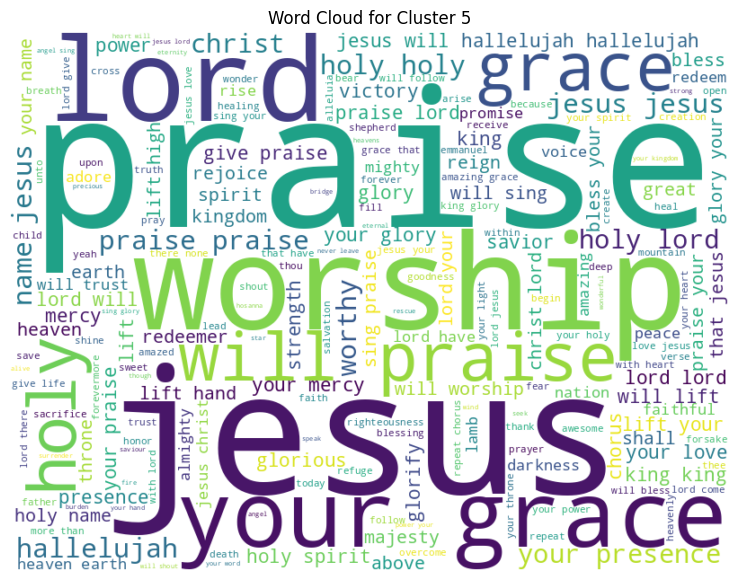

In [ ]:
generate_wordcloud_for_cluster(5, merged_df, X_tf, tfidf)

### Question 9:

Notice that the function takes a vectorizer and a matrix as input. In the example above, we are using the TF-IDF vectorizer and the corresponding matrix to show the word cloud for cluster 5.

1. What do you notice? What type of songs does the cluster contain?

2. Below, run the same function using the CountVectorizer (and its relative matrix) we defined in the previous section. Run the function for the same cluster.

3. Discuss the differences in the word cloud you obtain. Are there words whose size is now different? In light of the explanation we gave above for the TF-IDF weighting, can you guess why the results change?

1. Songs in cluster 5 contains "Jesus" "Worship" "Praise" a lot. This cluster contains mostly songs related to religions.

Number of artists in cluster 5: 26


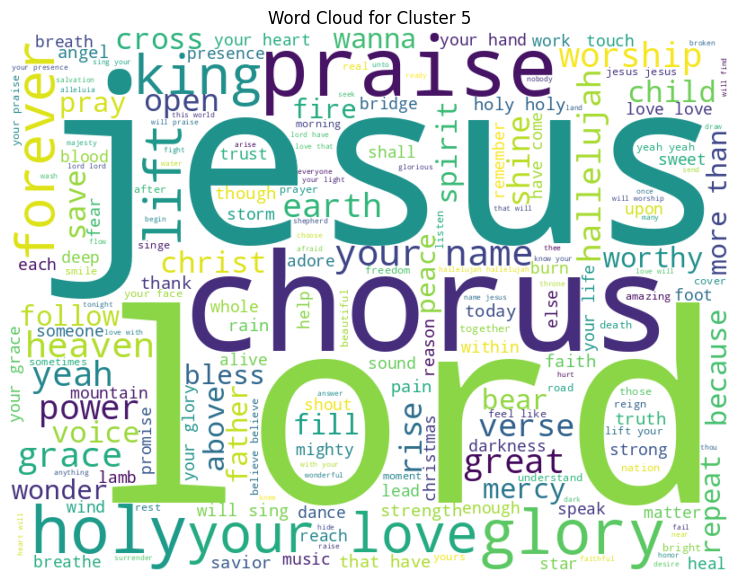

In [ ]:
generate_wordcloud_for_cluster(5, merged_df, X3, vectorizer3)

Number of artists in cluster 3: 167


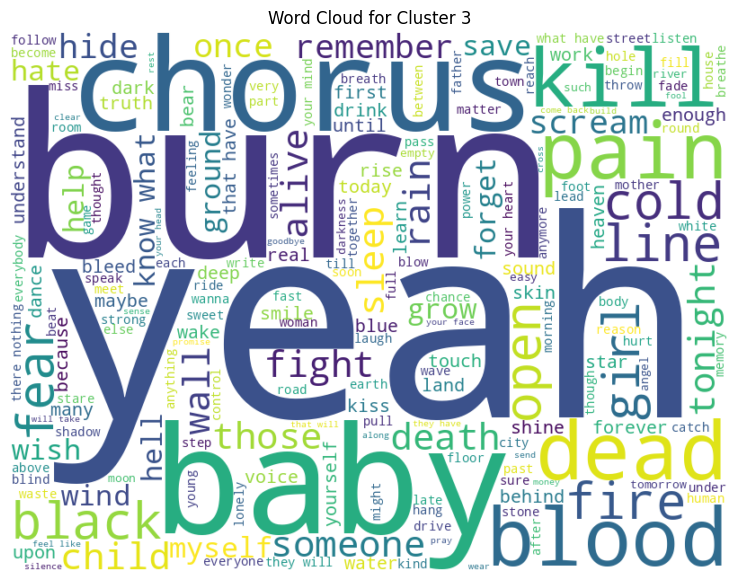

In [ ]:
generate_wordcloud_for_cluster(3, merged_df, X_tf, tfidf)

Number of artists in cluster 4: 235


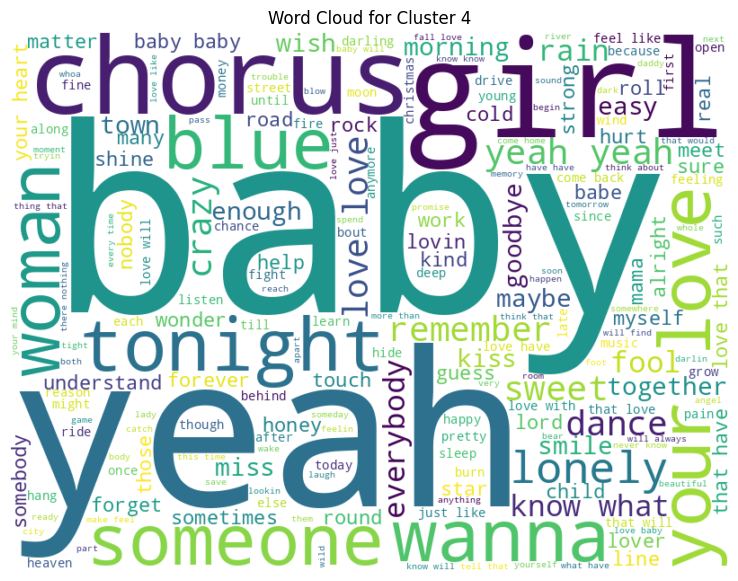

In [ ]:
generate_wordcloud_for_cluster(4, merged_df, X_tf, tfidf)

### Question 10:
In light of the two word clouds, as well as the result on the silhouette above, how do you comment the assignment of "The Beatles" to cluster 4, and the assignment of "Foo Fighters" to cluster 3?
Do you think that the quality of the assignment is similar in the two cases?
Contrast the words appearing in cluster 3 and in cluster 4, use only the wordcloud above. If you need, use the information in merged_df to see which other groups are assigned to the same cluster.

Which other clusters appear promising from the silouehtte graph?

Depending on the silhouette value above, cluster 3 does not have a high silhoutte value, while that of cluster 4 is quite stable. This suggests cluster 3 may have an overlap with other clusters, and does not have a clear difference; while cluster 4 is quite coherent in the feathers with other artists in cluster 4. Therefore, the quality of assignment will be higher in cluster 4 than cluster 3.

Given the word cloud of cluster 3 and cluster 4, they are similar to each other in the most commonly used words, with a difference in the topic of songs. Cluster 3 focuses on blood, death, pain and hate, which reflect the genre of Foo Fighters. And the words in cluster 4 include love, girl, woman, kiss, sweet, which showcase classic love songs.

Cluser 1, 6, 7 also look promising from the silouette graph.

## Principal Component Analysis

We can now move to dimensionality reduction.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=None,
                        max_features=10000,
                        use_idf=True,
                        lowercase=False,
                        ngram_range=(1,2),
                        max_df=0.90,
                        min_df=0.01,
                        token_pattern=r'(?u)\b\w{4,}\b'
                        )

X = tfidf.fit_transform(df_artist['tokens_simple'].apply(lambda tokens: " ".join(tokens)))

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, algorithm='randomized')
X_svd = svd.fit_transform(X)
explained_variance_ratio = svd.explained_variance_ratio_


In [ ]:
print(explained_variance_ratio)

[0.032105   0.03537467 0.02985576 0.01808841 0.01733706 0.01418605
 0.01013362 0.00973273 0.0092957  0.00841138 0.00816682 0.00693127
 0.00645895 0.00528989 0.00524172 0.00500201 0.00470926 0.00419069
 0.00403027 0.00382944 0.0038096  0.00369577 0.00345462 0.0033964
 0.00332959 0.00324587 0.00314863 0.00310105 0.00303729 0.00297169
 0.00291637 0.00283999 0.00277988 0.00275384 0.00266851 0.00265508
 0.00263534 0.00259917 0.00256439 0.00255265 0.00248789 0.0024766
 0.00246024 0.002414   0.00240218 0.00238488 0.00234826 0.00233081
 0.00229519 0.00228478]


### Question 11:
What can you say about the variance explained by the first 50 components?

The first 50 components capture around 30% of the total components of the text data. The first component captures about 3.2%, the second component captures about 3.5%, and the third captures about 2.99%, which are relatively high numbers.

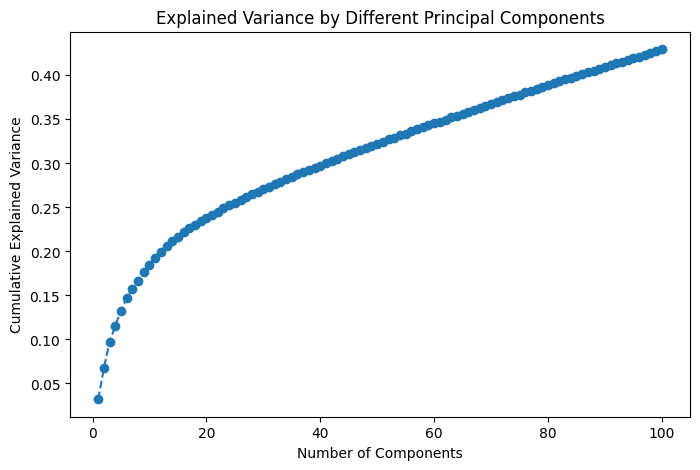

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_components = 100
explained_variance_ratios = []

for n in range(1, n_components + 1):
    svd = TruncatedSVD(n_components=n, algorithm='randomized')
    svd.fit(X)
    explained_variance_ratios.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), explained_variance_ratios, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.show()

### Question:

Which part of the variance are we explaining with the first 100 components?

In [ ]:
svd_100 = TruncatedSVD(n_components=100, algorithm='randomized')
svd_100.fit(X)
cumulative_variance_100 = svd_100.explained_variance_ratio_.sum()
print(cumulative_variance_100)

0.4297190069060947


We can now move to considering which tokens get a high weight in the first components, this is useful to understand the dimension that these components are capturing.

In [ ]:
svd = TruncatedSVD(n_components=3, algorithm='randomized')
svd.fit(X)

# Loadings for the first component
component_1_loadings = svd.components_[0]

# Assuming you have feature names from CountVectorizer
feature_names = tfidf.get_feature_names_out()
high_weight_features = sorted(zip(feature_names, component_1_loadings), key=lambda x: abs(x[1]), reverse=True)

for feature, loading in high_weight_features[:10]:  # Adjust the slice for more or fewer features
    print(f"{feature}: {loading}")

baby: 0.29719491113085805
yeah: 0.2328868576980857
chorus: 0.15987085895410244
girl: 0.15861523674715602
wanna: 0.09810631518837892
tonight: 0.08838729939040313
blue: 0.08292906715120088
yeah yeah: 0.07990498834933361
someone: 0.0710053420058002
dance: 0.06940651168251313


### Question 12:

Do the same for the second component. How would you describe these results? Is there a way to make sense of them?

In [ ]:
# Loadings for the second component
component_2_loadings = svd.components_[1]

# Assuming you have feature names from CountVectorizer
feature_names = tfidf.get_feature_names_out()
high_weight_features_2 = sorted(zip(feature_names, component_2_loadings), key=lambda x: abs(x[1]), reverse=True)

for feature, loading in high_weight_features_2[:10]:  # Adjust the slice for more or fewer features
    print(f"{feature}: {loading}")

nigga: 0.4856818606991356
niggas: 0.28372308453676776
yeah: 0.2571003284191038
shit: 0.2414804696318968
fuck: 0.23981397229535986
bitch: 0.21833307037639205
baby: 0.19151855596879555
girl: 0.13891877705733074
wanna: 0.12183613573184587
niggaz: 0.09516040933034009


The first dimension is capturing songs relating to romantic feelings, and the second is capturing insulting expressions. Although there are some overlap on "baby" "girl", the contrast is sharp. To make sense of them, some word like "baby" might be used together with insulting words in songs, which might be classed to this component.

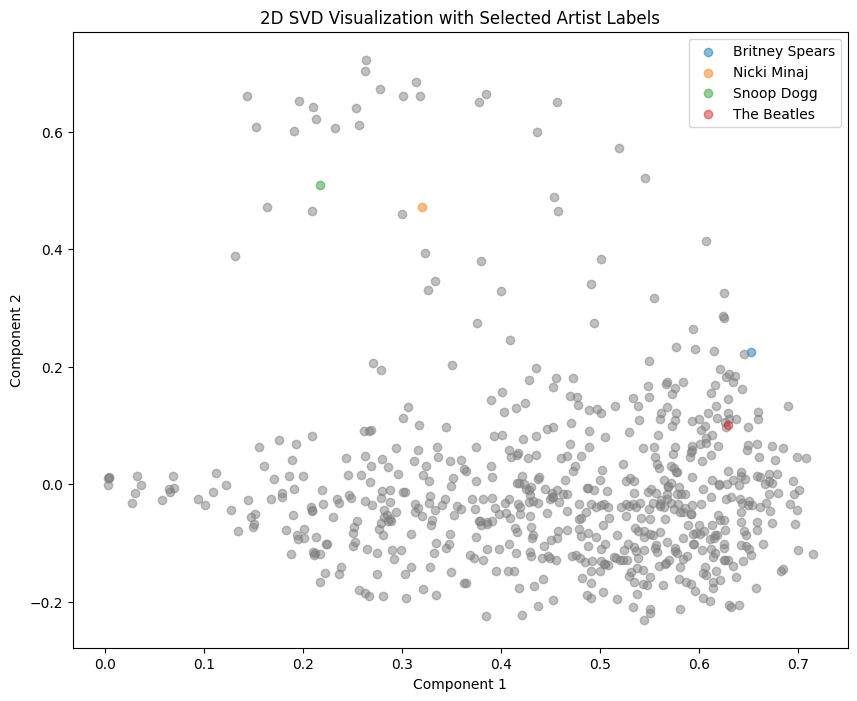

In [ ]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt

# Extract labels
labels = df_artist['artist'].values

specified_artists = (['Britney Spears', 'The Beatles', 'Nicki Minaj', 'Snoop Dogg']
                     )

# Fit SVD for 2 components for visualization
svd_2d = TruncatedSVD(n_components=2, algorithm='randomized')
X_svd_2d = svd_2d.fit_transform(X)

# Visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    if label in specified_artists:
        # Plot with label for specified artists
        plt.scatter(X_svd_2d[labels == label, 0], X_svd_2d[labels == label, 1], label=label, alpha=0.5)
    else:
        # Plot as dots without label for other artists
        plt.scatter(X_svd_2d[labels == label, 0], X_svd_2d[labels == label, 1], color='grey', alpha=0.5)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('2D SVD Visualization with Selected Artist Labels')
plt.show()

### Question 13:
Comment the results above (feel free to add more artists to highlight).
1. Given what you know about the two componets, comment the position of the four highlighted artists in the plane.  
2. What can you say about the distance between the four artists? What is a major limitation of using this 2d representation of artists?

1. Britney Spears and The Beatles express a lot about romantic feelings and make a little insulting words in their songs, while Nicki Minaj and Snoop Dogg show high rate of assertiveness, and moderate in attractiveness.

2. The distance between Britney Spears and The Beatles are close, and Nicki Minaj and Snoop Dogg are relatively close too. This suggests that the closer artists are closer in genre, expression, and style. Those with farther distance are not as similar. The limitation will be loss of information of text data. The 2 dimensions are only measuring the artists in the love/hate way.

## Latent Dirichlet Allocation

We will now study this dataset using a LDA topic model.

In [ ]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import re
# Your documents' token lists
texts = df['tokens_simple'].tolist()

# Create a dictionary representation of the documents
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=0.01, no_above=0.90, keep_n=10000)

# Define your regex pattern
token_pattern = re.compile(r'(?u)\b\w{4,}\b')

# Identify tokens that don't match the pattern
bad_ids = [tokenid for tokenid, token in dictionary.items() if not token_pattern.match(token)]

# Filter out these tokens
dictionary.filter_tokens(bad_ids=bad_ids)

dictionary.compactify()

# Convert document into a bag of word, following gensim package
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
num_topics = 8
passes = 15

temp = dictionary[0]  # This is only to "load" the dictionary
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,
                     passes=passes, eval_every=None)

In [ ]:
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.019*"your" + 0.018*"lord" + 0.014*"will" + 0.013*"with" + 0.013*"come" + 0.012*"heaven" + 0.012*"fire" + 0.012*"child" + 0.011*"soul" + 0.011*"name"')
(1, '0.040*"will" + 0.019*"that" + 0.019*"have" + 0.018*"with" + 0.018*"love" + 0.018*"come" + 0.016*"home" + 0.016*"night" + 0.016*"when" + 0.014*"dream"')
(2, '0.066*"baby" + 0.058*"yeah" + 0.045*"your" + 0.034*"want" + 0.032*"girl" + 0.028*"come" + 0.022*"wanna" + 0.018*"right" + 0.017*"just" + 0.016*"make"')
(3, '0.036*"like" + 0.033*"that" + 0.021*"with" + 0.016*"this" + 0.014*"they" + 0.013*"back" + 0.012*"nigga" + 0.011*"money" + 0.011*"fuck" + 0.011*"shit"')
(4, '0.049*"they" + 0.021*"have" + 0.017*"your" + 0.012*"with" + 0.012*"what" + 0.009*"their" + 0.009*"that" + 0.008*"people" + 0.008*"from" + 0.007*"some"')
(5, '0.045*"that" + 0.045*"love" + 0.039*"have" + 0.037*"know" + 0.023*"what" + 0.021*"just" + 0.021*"will" + 0.017*"would" + 0.016*"never" + 0.015*"want"')
(6, '0.057*"down" + 0.021*"well" + 0.019*"dance" + 0.015

### Question 14:
What do these scores mean? Can you relate them to any concept in the data generating process?
Can you intuitively recognize any topic?

These scores show a proportion of words in a topic.

In the data generating process, each song has a vector of topic, and the topics are composed of a distribution of tokens. The words shown here is the topics' word distributions.

Some of the topics are intuitive, for example, the second topic (number 1) is related to love and home, the third topic (number 2) is directly love related.

(NOTE: The code below will take a 1 hour to run). If you do not have time, just reduce the number of points to be calculated by changing

```
start, limit, step = 2, 14, 3
```


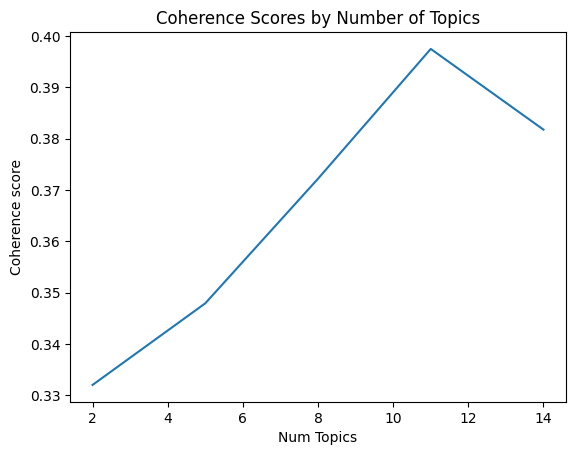

Num Topics = 2, Coherence Value = 0.332
Num Topics = 5, Coherence Value = 0.3479
Num Topics = 8, Coherence Value = 0.3722
Num Topics = 11, Coherence Value = 0.3975
Num Topics = 14, Coherence Value = 0.3817


In [ ]:
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import numpy as np

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    for num_topics in range(start, limit + 1, step):
        # Create a new LDA model for each number of topics
        id2word = dictionary.id2token

        model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,
                         passes=passes, eval_every=None)
        # Compute the coherence score for the model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

# Parameters for the coherence computation
start, limit, step = 2, 14, 3

# Ensure your 'texts', 'dictionary', and 'corpus' are correctly prepared before this step
coherence_values = compute_coherence_values(dictionary, corpus, texts, start, limit, step)

# Plotting the coherence scores
x = range(start, limit + 1, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores by Number of Topics")
plt.show()

# Printing the coherence scores for each number of topics
for num_topics, coherence_value in zip(x, coherence_values):
    print(f"Num Topics = {num_topics}, Coherence Value = {round(coherence_value, 4)}")


### Question 15:
Given the results above, which number of topics would you consider calculating? How else would you proceed to decide how many topics to introduce in your model?

I would calculate 11 topics. I would try to use Elbow methods introduced above. I would also inspect the topics myself to decide how many topics I want and what they are.

In [ ]:
print(texts[0])

['look', 'at', 'her', 'face', 'it', 'be', 'wonderful', 'face', 'and', 'it', 'mean', 'something', 'special', 'to', 'look', 'at', 'the', 'way', 'that', 'she', 'smile', 'when', 'she', 'see', 'how', 'lucky', 'can', 'one', 'fellow', 'be', 'she', 'be', 'just', 'my', 'kind', 'of', 'girl', 'she', 'make', 'feel', 'fine', 'who', 'could', 'ever', 'believe', 'that', 'she', 'could', 'be', 'mine', 'she', 'be', 'just', 'my', 'kind', 'of', 'girl', 'without', 'she', 'be', 'blue', 'and', 'if', 'she', 'ever', 'leave', 'what', 'could', 'do', 'what', 'could', 'do', 'and', 'when', 'we', 'go', 'for', 'walk', 'in', 'the', 'park', 'and', 'she', 'hold', 'and', 'squeeze', 'my', 'hand', 'we', 'will', 'go', 'on', 'walk', 'for', 'hour', 'and', 'talk', 'about', 'all', 'the', 'thing', 'that', 'we', 'plan', 'she', 'be', 'just', 'my', 'kind', 'of', 'girl', 'she', 'make', 'feel', 'fine', 'who', 'could', 'ever', 'believe', 'that', 'she', 'could', 'be', 'mine', 'she', 'be', 'just', 'my', 'kind', 'of', 'girl', 'without', '

In [ ]:
texts = df['tokens_simple'].tolist()

In [ ]:
document_topics = lda_model.get_document_topics(corpus[0])

for topic_id, topic_proportion in document_topics:
    print(f"Topic {topic_id}: {topic_proportion * 100:.2f}%")

Topic 0: 4.83%
Topic 1: 79.62%
Topic 2: 11.73%
Topic 4: 3.14%


### Question 16:
What are we doing in the code above?
Would you say that these results make sense?

The code above is showing the words contained in the first document, and tracks the topic distribution of the first document/song. This shows that the first song has a 79.62% probability of being Topic 1, which makes a lot of sense for topic 1 shows feelings of love and home.

In [ ]:
num_topics = lda_model.num_topics
topic_coverage = np.zeros(num_topics)

for doc_bow in corpus:
    for topic_id, proportion in lda_model.get_document_topics(doc_bow, minimum_probability=0):
        topic_coverage[topic_id] += proportion

# Normalize by the number of documents to get the average coverage
topic_coverage /= len(corpus)

for topic_id, coverage in enumerate(topic_coverage):
    print(f"Topic {topic_id}: {coverage * 100:.2f}%")

Topic 0: 12.41%
Topic 1: 26.02%
Topic 2: 7.06%
Topic 3: 6.49%
Topic 4: 12.17%
Topic 5: 17.72%
Topic 6: 6.93%
Topic 7: 11.20%


### Question 17:
Explain in your own words the difference between the results above and what you would get by running a cluster algorithm setting the number of clusters equal to 8. Do you think you would get similar results?

The results above shows the average proportion of topics of all the documents, and one document can contain several topics, each illustrated by proportion/probability.

When we use clustering, each document is assigned one cluster, some of which might not be reliable because of overlapping or lack of coherence. And clustering is not in the form of proportion. They are very dissimilar.